# Test du ImageLoader amélioré

Ce notebook teste le nouveau `ImageLoader` avec gestion d'erreurs et logging sur le dataset COVID-19.

## 1. Configuration et Imports

In [2]:
import sys
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Ajouter le répertoire src au path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.features.Pipelines.transformateurs.image_loaders import ImageLoader

# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")

Project root: /home/cepa/DST/projet_DS/DS_COVID_ORGA
Python version: 3.10.12 (main, Nov  4 2025, 08:48:33) [GCC 11.4.0]


## 2. Chargement des chemins d'images

In [3]:
# Définir les chemins vers les données
data_root = project_root / "data" / "raw" / "COVID-19_Radiography_Dataset" / "COVID-19_Radiography_Dataset"

# Catégories disponibles
categories = {
    'COVID': data_root / "COVID" / "images",
    'Normal': data_root / "Normal" / "images",
    'Lung_Opacity': data_root / "Lung_Opacity" / "images",
    'Viral_Pneumonia': data_root / "Viral Pneumonia" / "images"
}

# Vérifier que les dossiers existent
for name, path in categories.items():
    if path.exists():
        n_images = len(list(path.glob('*.png'))) + len(list(path.glob('*.jpg')))
        print(f"✓ {name}: {n_images} images trouvées")
    else:
        print(f"✗ {name}: Dossier non trouvé - {path}")

✓ COVID: 3616 images trouvées
✓ Normal: 10192 images trouvées
✓ Lung_Opacity: 6012 images trouvées
✓ Viral_Pneumonia: 1345 images trouvées


## 3. Récupération d'un échantillon d'images

In [4]:
# Charger un échantillon de chaque catégorie
n_samples_per_category = 50

image_paths = []
labels = []

for category_name, category_path in categories.items():
    if not category_path.exists():
        continue
    
    # Récupérer les fichiers PNG et JPG
    files = list(category_path.glob('*.png')) + list(category_path.glob('*.jpg'))
    
    # Prendre un échantillon
    sample = files[:n_samples_per_category]
    
    image_paths.extend(sample)
    labels.extend([category_name] * len(sample))

print(f"\nTotal d'images à charger: {len(image_paths)}")
print(f"Distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")


Total d'images à charger: 200
Distribution: {np.str_('COVID'): np.int64(50), np.str_('Lung_Opacity'): np.int64(50), np.str_('Normal'): np.int64(50), np.str_('Viral_Pneumonia'): np.int64(50)}


## 4. Test du ImageLoader - Configuration basique

In [17]:
# Créer une instance du loader avec configuration par défaut
loader_basic = ImageLoader(
    img_size=(128, 128),
    color_mode='L',  # Niveaux de gris
    verbose=True
)

# Charger les images
images_loaded = loader_basic.transform(image_paths)

print(f"\n{'='*60}")
print(f"Résultats du chargement:")
print(f"{'='*60}")
print(f"Images chargées avec succès: {loader_basic.n_images_loaded_}")
print(f"Images échouées: {len(loader_basic.failed_images_)}")
if loader_basic.failed_images_:
    print(f"Chemins échoués: {loader_basic.failed_images_}")

TypeError: ImageLoader.fit() takes 1 positional argument but 2 were given

## 5. Visualisation des images chargées

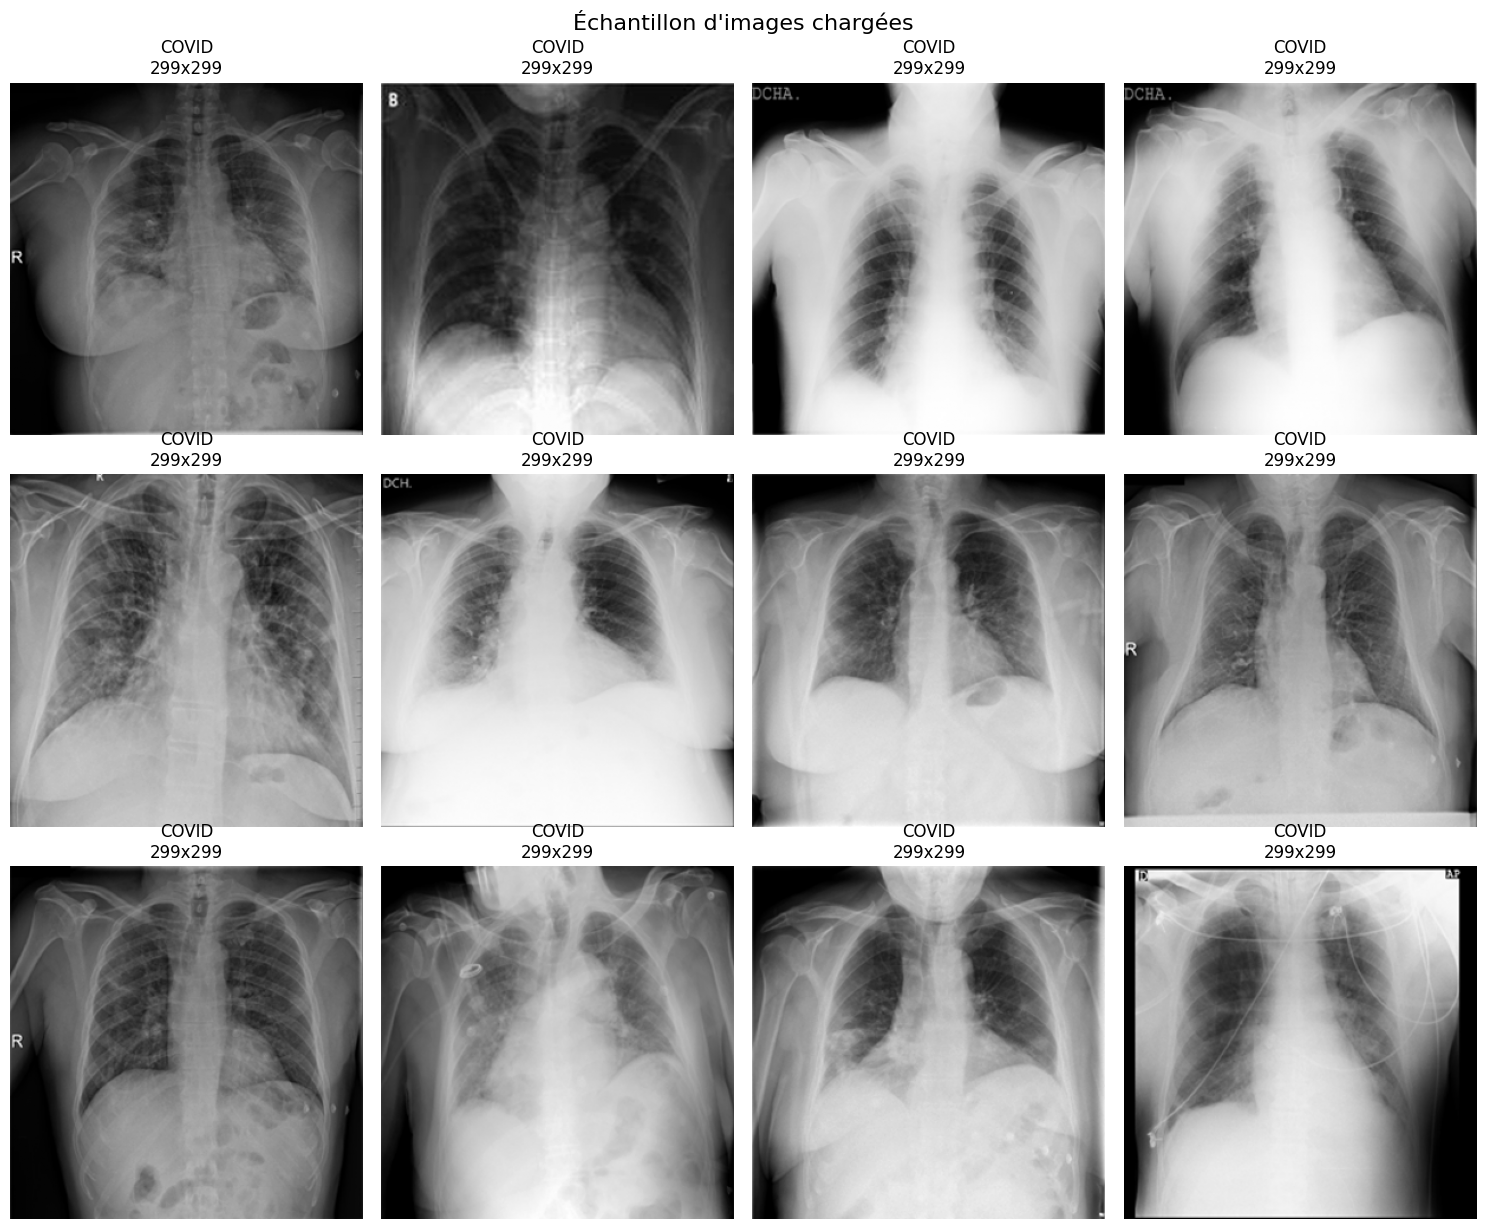

In [11]:
# Afficher un échantillon des images chargées
n_display = min(12, len(images_loaded))
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.flatten()

for idx in range(n_display):
    ax = axes[idx]
    img = images_loaded[idx]
    label = labels[idx]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{label}\n{img.size[0]}x{img.size[1]}")
    ax.axis('off')

# Masquer les axes inutilisés
for idx in range(n_display, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Échantillon d\'images chargées', fontsize=16, y=1.02)
plt.show()

## 6. Statistiques sur les images

In [12]:
# Analyser les dimensions des images
image_sizes = [img.size for img in images_loaded]
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

print(f"Statistiques des dimensions:")
print(f"{'='*60}")
print(f"Largeur - Min: {min(widths)}, Max: {max(widths)}, Moyenne: {np.mean(widths):.1f}")
print(f"Hauteur - Min: {min(heights)}, Max: {max(heights)}, Moyenne: {np.mean(heights):.1f}")
print(f"\nDimensions uniques: {set(image_sizes)}")

# Modes des images
image_modes = [img.mode for img in images_loaded]
print(f"\nModes des images: {set(image_modes)}")

Statistiques des dimensions:
Largeur - Min: 299, Max: 299, Moyenne: 299.0
Hauteur - Min: 299, Max: 299, Moyenne: 299.0

Dimensions uniques: {(299, 299)}

Modes des images: {'L'}


## 7. Test avec validation de chemins désactivée

In [14]:
# Ajouter quelques chemins invalides pour tester la gestion d'erreurs
test_paths = image_paths[:5].copy()
test_paths.append(Path("/chemin/invalide/image.png"))  # Chemin inexistant
test_paths.append(Path("/tmp/fake_image.jpg"))  # Autre chemin invalide

print(f"Test avec {len(test_paths)} chemins (dont 2 invalides)\n")

loader_test = ImageLoader(
    color_mode='L',
    validate_paths=True,
    fail_on_error=False,  # Continue malgré les erreurs
    verbose=True
)

images_test = loader_test.transform(test_paths)

print(f"\nRésultats:")
print(f"Images chargées: {loader_test.n_images_loaded_}/{len(test_paths)}")
print(f"Images échouées: {len(loader_test.failed_images_)}")

2026-01-07 21:48:34,328 - src.features.Pipelines.transformateurs.image_loaders - INFO - Loading 7 images...


Test avec 7 chemins (dont 2 invalides)



Loading images:   0%|          | 0/7 [00:00<?, ?it/s]2026-01-07 21:48:34,354 - src.features.Pipelines.transformateurs.image_loaders - WARNING - Path does not exist: /chemin/invalide/image.png
2026-01-07 21:48:34,357 - src.features.Pipelines.transformateurs.image_loaders - WARNING - Path does not exist: /tmp/fake_image.jpg
Loading images: 100%|██████████| 7/7 [00:00<00:00, 326.30it/s]
2026-01-07 21:48:34,360 - src.features.Pipelines.transformateurs.image_loaders - INFO - Loading completed: 5/7 images loaded successfully (71.4%)
2026-01-07 21:48:34,361 - src.features.Pipelines.transformateurs.image_loaders - WARNING - Failed to load 2 images



Résultats:
Images chargées: 5/7
Images échouées: 2


## 8. Test en mode couleur (RGB)

2026-01-07 21:48:47,665 - src.features.Pipelines.transformateurs.image_loaders - INFO - Loading 5 images...
Loading images: 100%|██████████| 5/5 [00:00<00:00, 377.25it/s]
2026-01-07 21:48:47,693 - src.features.Pipelines.transformateurs.image_loaders - INFO - Loading completed: 5/5 images loaded successfully (100.0%)


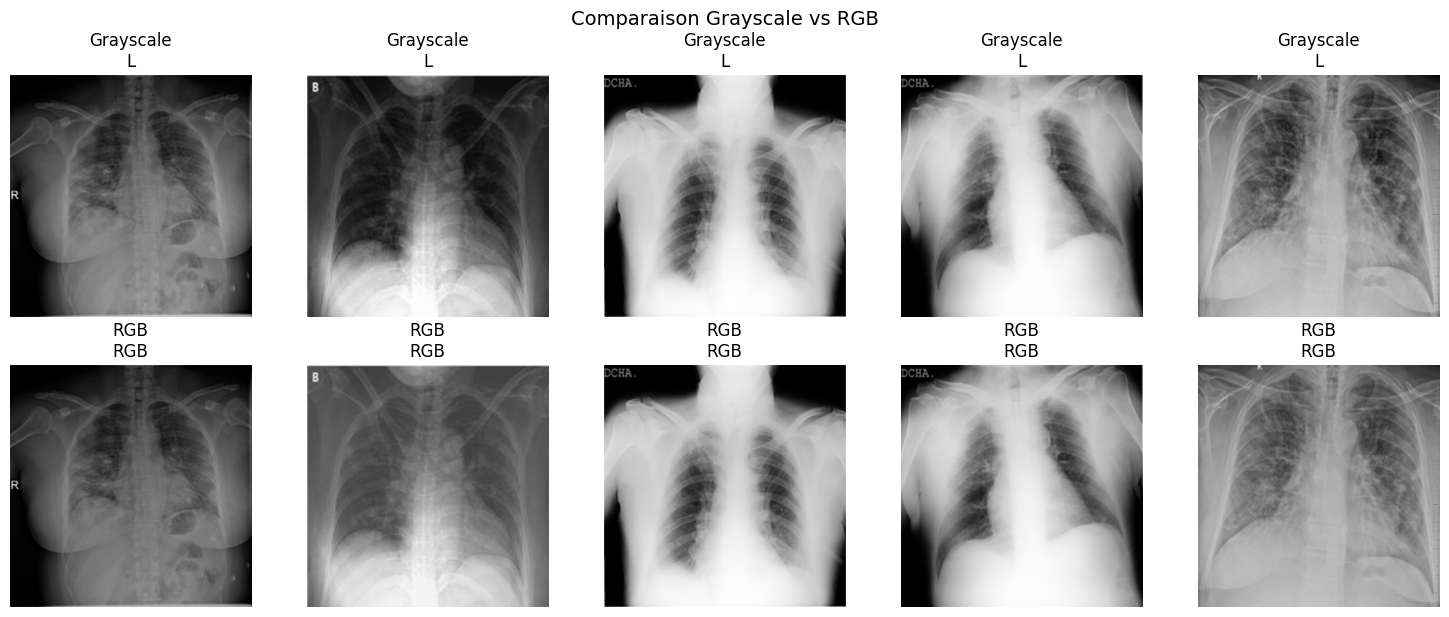


Mode grayscale: L
Mode RGB: RGB


In [15]:
# Charger en mode RGB pour comparaison
loader_rgb = ImageLoader(
    color_mode='RGB',
    verbose=True
)

images_rgb = loader_rgb.transform(image_paths[:5])

# Comparer grayscale vs RGB
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx in range(min(5, len(images_rgb))):
    # Grayscale
    axes[0, idx].imshow(images_loaded[idx], cmap='gray')
    axes[0, idx].set_title(f'Grayscale\n{images_loaded[idx].mode}')
    axes[0, idx].axis('off')
    
    # RGB
    axes[1, idx].imshow(images_rgb[idx])
    axes[1, idx].set_title(f'RGB\n{images_rgb[idx].mode}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.suptitle('Comparaison Grayscale vs RGB', fontsize=14, y=1.02)
plt.show()

print(f"\nMode grayscale: {images_loaded[0].mode}")
print(f"Mode RGB: {images_rgb[0].mode}")

## 9. Résumé et conclusions

In [16]:
print("\n" + "="*70)
print("RÉSUMÉ DES TESTS")
print("="*70)

print(f"\n✓ ImageLoader fonctionne correctement")
print(f"✓ Gestion d'erreurs opérationnelle")
print(f"✓ Validation de chemins fonctionnelle")
print(f"✓ Support grayscale et RGB")
print(f"✓ Logging détaillé et informatif")

print(f"\nStatistiques finales:")
print(f"  - Total d'images testées: {len(image_paths)}")
print(f"  - Catégories: {len(set(labels))}")
print(f"  - Taux de réussite: {(loader_basic.n_images_loaded_/len(image_paths))*100:.1f}%")

print("\n" + "="*70)


RÉSUMÉ DES TESTS

✓ ImageLoader fonctionne correctement
✓ Gestion d'erreurs opérationnelle
✓ Validation de chemins fonctionnelle
✓ Support grayscale et RGB
✓ Logging détaillé et informatif

Statistiques finales:
  - Total d'images testées: 200
  - Catégories: 4
  - Taux de réussite: 100.0%

